In [61]:
import os
import warnings
from collections import defaultdict
from copy import deepcopy
from datetime import datetime

import matplotlib as mpl
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from classify import temperature
from classify.data.responses import responses_to_traffic_array
from classify.data.traffic import load_traffic
from classify.scenario.bridge import healthy_damage, pier_disp_damage
from classify.scenario.traffic import normal_traffic
from fem.run.opensees import OSRunner
from model.bridge import Point
from model.bridge.bridge_705 import bridge_705_3d, bridge_705_med_config
from model.response import ResponseType
from plot import legend_marker_size, plt
from plot.temperature import plot_day_lines
from util import print_i, resize_units

warnings.filterwarnings("ignore")

In [54]:
c = bridge_705_med_config(bridge_705_3d)
# Set the directory of where to save/load responses.
c.root_generated_data_dir = os.path.join("/Users/jeremy/Desktop/mesh-med-600", c.root_generated_data_dir)
point_a = Point(x=34.955, y=0, z=29.226 - 16.6)

INFO: Loaded vehicle data from /Users/jeremy/cs/bridge-dss/data/a16-data/a16.csv in 0.13s
WARN: Vehicle PDF sums to 99.5, adjusted to sum to 1


# Annual temperature
Annual temperature, which will have to be accounted for in damage detection.

In [55]:
# Short aliases for response types.
rt_y = ResponseType.YTranslation
rt_s = ResponseType.Strain

# Create functions to resize, and unit strings, for each response type.
resize_y, units_y = resize_units(rt_y.units())
resize_s, _ = resize_units(rt_s.units())

# Load minute-by-minute temperature data for the year.
from_ = datetime.fromisoformat(f"2019-01-01T00:00")
to = datetime.fromisoformat(f"2019-12-31T23:59")
temps_year = temperature.from_to_mins(temperature.load("holly-springs"), from_, to)

# Interpolate the temperatures into a Dutch range.
tmin, tmax = min(temps_year["temp"]), max(temps_year["temp"])
new_tmin, new_tmax = -5, 35
temps_year["temp"] = interp1d(np.linspace(tmin, tmax, 1000), np.linspace(new_tmin, new_tmax, 1000))(temps_year["temp"])

effect_year = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_year["temp"], len_per_hour=60)
effect_year = resize_y(effect_year)


def plot_temp_year():
    plt.scatter(temps_year["datetime"], temps_year["temp"], s=1)
    plt.ylabel("Temperature (C)")
#     ax = plt.twinx()
#     ax.scatter(temps_year["datetime"], effect_year, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature in 2019")

# plot_temp_year()

# 2 week temperature
Zooming in a little bit, to show the daily fluctuation in temperature, and how it can change over a number of days.

In [56]:
from_ = datetime.fromisoformat(f"2019-07-01T00:00")
to = datetime.fromisoformat(f"2019-07-14T23:59")
temps_july_1_14 = temperature.from_to_mins(temps_year, from_, to)
july_1_14_i, july_1_14_j = temperature.from_to_indices(temps_year, from_, to)

# These lines should use from_to_indices.
# effect_july_1_14 = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_year["temp"], len_per_hour=60)
# effect_july_1_14 = resize_y(effect_july_1_14)


def plot_temp_two_weeks():
    plot_day_lines(temps_july_1_14["datetime"])
    plt.plot(temps_july_1_14["datetime"], temps_july_1_14["temp"])
    plt.ylabel("Temperature (C)")
    plt.legend(loc="upper right")
#     ax = plt.twinx()
#     ax.scatter(temps_month["datetime"], effect_month, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature 1 - 14 July 2019")

# plot_temp_two_weeks()

# Daily temperature
Damage detection will be done on sensor responses over a shorter period of time. The next plot shows such changes.

In [57]:
from_ = datetime.fromisoformat(f"2019-07-01T00:00")
to = datetime.fromisoformat(f"2019-07-02T23:59")
temps_july_1_2 = temperature.from_to_mins(temps_year, from_, to)
july_1_2_i, july_1_2_j = temperature.from_to_indices(temps_year, from_, to)

# These lines should use from_to_indices.
# effect_july_1_2 = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_year["temp"], len_per_hour=60)
# effect_july_1_2 = resize_y(effect_july_1_2)


def plot_temp_days():
    plt.plot(temps_july_1_2["datetime"], temps_july_1_2["temp"])
    plot_day_lines(temps_july_1_2["datetime"])
    plt.ylabel("Temperature (C)")
    plt.legend(loc="upper right")
#     ax = plt.twinx()
#     ax.scatter(temps_days["datetime"], effect_days, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature 1 - 2 July 2019")
    
# plot_temp_days()

# Thesis temperature plot
Putting the three plots together for one concise plot for the thesis.

INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/temperature/temp.pdf


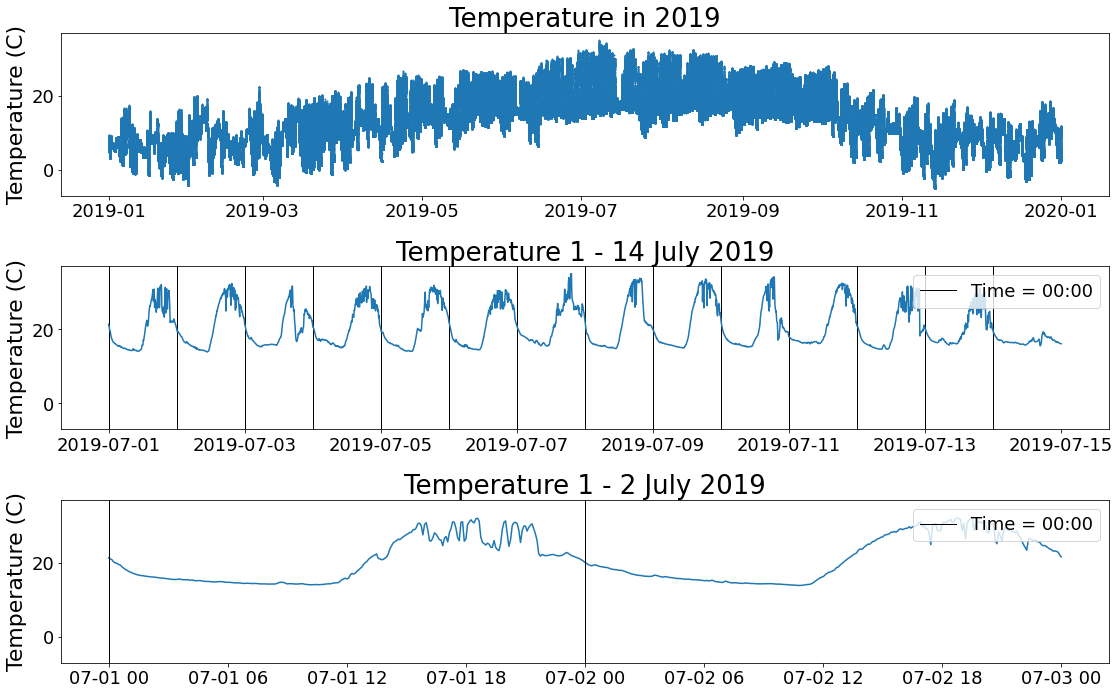

In [58]:
plt.landscape()
ax0 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
plot_temp_two_weeks()
ax1 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
plot_temp_days()
ax2 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
plot_temp_year()

ymin, ymax = np.inf, -np.inf
for ax in [ax0, ax1, ax2]:
    if ax.get_ylim()[0] < ymin:
        ymin = ax.get_ylim()[0]
    if plt.ylim()[1] > ymax:
        ymax = ax.get_ylim()[1]
for ax in [ax0, ax1, ax2]:
    ax.set_ylim((ymin, ymax))

plt.tight_layout()
plt.savefig(c.get_image_path("temperature", "temp.pdf"))

# Traffic
24 minutes of traffic data is used for damage detection. Temperature will be sped up such that 24 hours of temperature change takes place over the 24 minutes of traffic simulation.

In [59]:
total_mins = 24
total_seconds = total_mins * 60

# Create the traffic.
traffic_scenario = normal_traffic(c=c, lam=5, min_d=2)
traffic_sequence, traffic, traffic_array = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
)
traffic_array.shape

/Users/jeremy/Desktop/mesh-med-600/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-1440-0,01.npy


(144001, 2400)

# Collecting responses
Responses are collected here over two damage scenarios (healthy, pier 5 settlement @ 1 mm) for the 48 minutes of traffic simulation, at a single sensor. These strains and vertical translation will allow us to see what the traffic signal looks like and how the data distributions are different under each damage scenario.

In [64]:
damage_scenarios = [healthy_damage, pier_disp_damage([(5, 1 / 1000)])]
damage_names = ["Healthy", "Pier 5 settlement by 1mm"]
response_types = [rt_y, rt_s]
sensor_point = Point(x=21, y=0, z=-8.4)  # Sensor point to investigate.

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, damage_scenario in enumerate(damage_scenarios):
    for r_i, response_type in enumerate(response_types):
        responses[d_i][r_i] = responses_to_traffic_array(
            c=c,
            traffic_array=traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=[sensor_point],
            sim_runner=OSRunner(c),
        ).T[0]  # Responses from a single point.
responses = np.array(responses)
responses.shape

(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)uilt FEMResponses in 0.01s, (ResponseType.YTranslation)
(2400, 1)


(2, 2, 144001)

# Example of traffic responses
The vertical translation and strain responses from the healthy bridge and under pier settlement, at the same point, are compared to get an idea of what the signal due to traffic looks like. At this sensor the vertical translation and strain responses are highly correlated, 0.96.

(-0.930189366436259, 0.0)
(-0.930189366436259, 0.0)


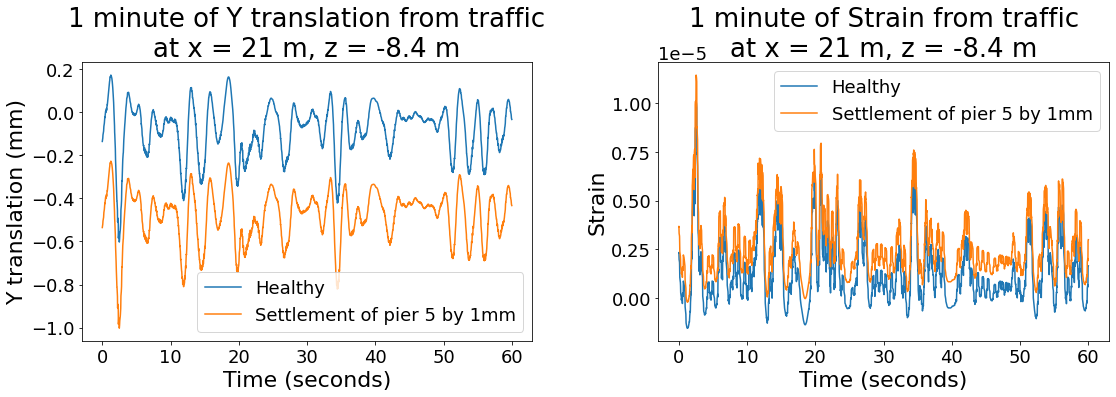

In [66]:
_y_h_48m, _s_h_48m = responses[0]  # Healthy bridge. Vertical translation and strain.
_y_p_48m, _s_p_48m = responses[1]  # Pier settlement. Vertical translation and strain.
# Cut to 1 minute.
y_h_1m, s_h_1m = _y_h_48m[:int(len(_y_h_48m) / total_mins)], _s_h_48m[:int(len(_s_h_48m) / total_mins)]
y_p_1m, s_p_1m = _y_p_48m[:int(len(_y_p_48m) / total_mins)], _s_p_48m[:int(len(_s_p_48m) / total_mins)]

plt.subplot(2, 2, 1) 
plt.plot(np.arange(len(y_h_1m)) * c.sensor_hz, resize_y(y_h_1m), label="Healthy")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"Time (seconds)")
plt.title(f"1 minute of {rt_y.name()} from traffic\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(s_h_1m)) * c.sensor_hz, resize_s(s_h_1m), label="Healthy")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel(f"Time (seconds)")
plt.title(f"1 minute of {rt_s.name()} from traffic\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.subplot(2, 2, 1)
plt.plot(np.arange(len(y_p_1m)) * c.sensor_hz, resize_y(y_p_1m), label="Settlement of pier 5 by 1mm")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(s_p_1m)) * c.sensor_hz, resize_s(s_p_1m), label="Settlement of pier 5 by 1mm")
plt.legend()
plt.tight_layout()

print(pearsonr(y_h_1m, s_h_1m))
print(pearsonr(y_p_1m, s_p_1m))

# Example of temperature effect
It is also useful to get an idea of what the effect of temperature is like. The responses due to temperature are clearly greater than the traffic responses.  The vertical translation and strain responses due to temperature are entirely correlated, this will possible change once the temperature model modifies the linear temperature component throughout the day, meeting this week to get an idea of approximate values.

In [26]:
########
# July #
########

temp_effect_y_48m = temperature.get_effect(
    c=c,
    response_type=rt_y,
    points=[sensor_point],
    temps=temps_month["temp"],  # All of July.
    responses=[y_h_48m],
    # Traffic data is sampled per minute. Here sped up by x60.
    # Since the given data is 48 minutes of traffic, this
    # results in 48 hours worth of temperature data taking
    # place over 48 minutes.
    speed_up=60,
)[0]  # Responses from a single point.

temp_effect_s_48m = temperature.get_effect(
    c=c,
    response_type=rt_s,
    points=[sensor_point],
    temps=temps_month["temp"],
    responses=[y_h_48m],
    speed_up=60,
)[0]  # Responses from a single point.

############
# December #
############

from_ = datetime.fromisoformat(f"2019-12-29T23:58")
to = datetime.fromisoformat(f"2019-12-31T23:59")
temps_days_2 = temperature.from_to_mins(temps_year, from_, to)

temp_effect_y_2_48m = temperature.get_effect(
    c=c,
    response_type=rt_y,
    points=[sensor_point],
    temps=temps_days_2["temp"],
    responses=[y_h_48m],
    # Traffic data is sampled per minute. Here sped up by x60.
    # Since the given data is 48 minutes of traffic, this
    # results in 48 hours of temperature data.
    speed_up=60,
)[0]  # Responses from a single point.

temp_effect_s_2_48m = temperature.get_effect(
    c=c,
    response_type=rt_s,
    points=[sensor_point],
    temps=temps_days_2["temp"],
    responses=[y_h_48m],
    speed_up=60,
)[0]  # Responses from a single point.

temp_effect_y_2_48m.shape

NameError: name 'temps_month' is not defined

In [ ]:
x = np.arange(len(responses[0][0])) * c.sensor_hz / 60

plt.subplot(2, 2, 1)
plt.plot(x, resize_y(temp_effect_y_48m), label="July 1 - 2")
plt.plot(x, resize_y(temp_effect_y_2_48m), label="December 30 - 31")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title(f"{rt_y.name()} from temperature\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.legend(loc="upper right")

plt.subplot(2, 2, 2)
plt.plot(x, resize_s(temp_effect_s_48m), label="July 1 - 2")
plt.plot(x, resize_s(temp_effect_s_2_48m), label="December 30 - 31")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title(f"{rt_s.name()} from temperature\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.legend(loc="upper right")
    
plt.tight_layout()
pearsonr(temp_effect_y_48m, temp_effect_s_48m)
plt.savefig(c.get_image_path("classify/detection", "temperature-difference.pdf"))